In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from torchvision.models import vgg16_bn
from fastai.callbacks import *

In [2]:
path = Path('.')
path_hr = path/'train'
path_lr = path/'train_small-96'
path_mr = path/'train_small-256'

In [3]:
il = ImageList.from_folder(path_hr)
il

ImageList (26684 items)
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: train

In [4]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
# sets = [(path_lr, 96), (path_mr, 256)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

In [6]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [7]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: str(x).replace('train_small-96', 'train'))
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [8]:
data = get_data(bs,size)

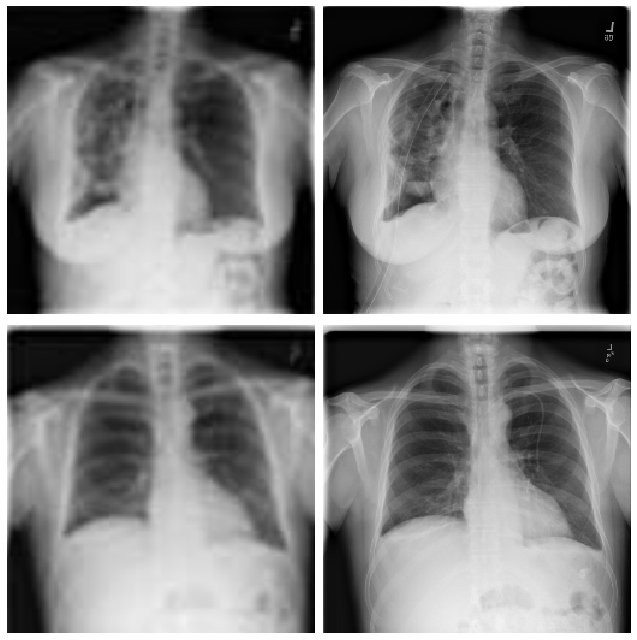

In [9]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [10]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [11]:
base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [12]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [13]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [14]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [15]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04
Min loss divided by 10: 1.32E-03


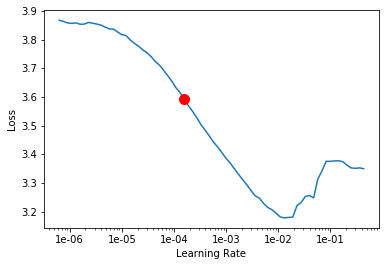

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
lr = 4.37E-03

def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.637166,1.666970,0.074715,0.165571,0.214194,0.100088,0.305454,0.639768,0.167180,02:53
1,1.569204,1.604756,0.071434,0.160030,0.206909,0.096851,0.289137,0.618838,0.161557,02:55
2,1.532910,1.568173,0.064166,0.156863,0.202779,0.095604,0.281947,0.606622,0.160192,02:56
3,1.520409,1.555565,0.062537,0.154959,0.200506,0.093994,0.284963,0.600987,0.157620,02:56
4,1.506267,1.559270,0.067149,0.157301,0.202097,0.095017,0.279930,0.598534,0.159242,02:57
5,1.501638,1.526713,0.064247,0.155040,0.199256,0.093583,0.269270,0.588434,0.156883,02:56
6,1.490993,1.530731,0.064380,0.152669,0.197438,0.092755,0.276776,0.591016,0.155696,02:57
7,1.494045,1.531437,0.064813,0.153871,0.198042,0.093135,0.275368,0.589735,0.156472,02:57
8,1.469260,1.486214,0.062341,0.150854,0.193584,0.090443,0.264121,0.573231,0.151640,02:57
9,1.411066,1.432147,0.059543,0.146095,0.187118,0.087917,0.250020,0.553100,0.148354,02:57


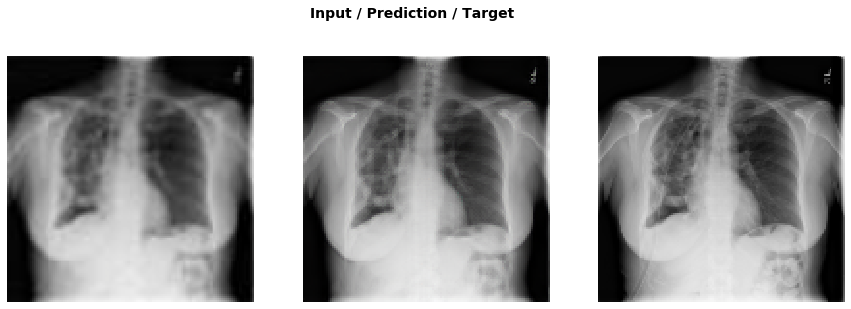

In [22]:
do_fit('1a', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.404439,1.430488,0.059604,0.146070,0.187025,0.087874,0.249206,0.552450,0.148259,03:07
1,1.408218,1.427759,0.059354,0.145656,0.186512,0.087679,0.249243,0.551260,0.148055,03:10
2,1.410169,1.424147,0.059318,0.145649,0.186165,0.087567,0.247659,0.549917,0.147872,03:11
3,1.406901,1.425305,0.059359,0.145377,0.186163,0.087634,0.248591,0.550201,0.147981,03:11
4,1.402893,1.422879,0.059457,0.145241,0.186004,0.087640,0.247576,0.548995,0.147964,03:10
5,1.403212,1.415994,0.059362,0.145046,0.185465,0.087346,0.244832,0.546408,0.147534,03:11
6,1.400213,1.416178,0.059431,0.144784,0.185313,0.087379,0.244872,0.546794,0.147605,03:11
7,1.400270,1.415213,0.058961,0.144107,0.184822,0.086979,0.247294,0.546334,0.146716,03:11
8,1.391440,1.410922,0.058808,0.143942,0.184180,0.086754,0.246384,0.544137,0.146716,03:12
9,1.386847,1.403041,0.058491,0.143208,0.183312,0.086335,0.244305,0.541403,0.145987,03:11


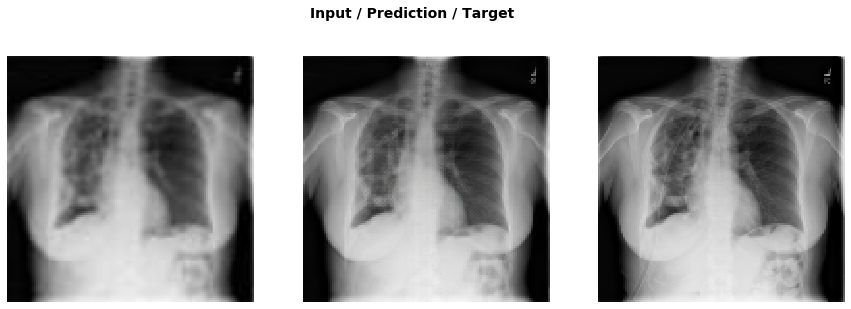

In [23]:
learn.unfreeze()
do_fit('1b', slice(1e-5,lr))

In [8]:
data = get_data(12,size*2)

In [25]:
learn.data = data
learn.freeze()
gc.collect()

28323

In [18]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.175493,1.276404,0.080003,0.208185,0.231115,0.086417,0.221303,0.369459,0.079922,11:28
1,1.136247,1.213558,0.075937,0.198594,0.219975,0.083187,0.212770,0.345431,0.077665,11:34
2,1.098771,1.151319,0.073201,0.193003,0.212904,0.080433,0.188065,0.328354,0.075360,11:33
3,1.072926,1.124424,0.069979,0.188455,0.207446,0.078861,0.185937,0.319576,0.074169,11:33
4,1.067222,1.113160,0.072257,0.187756,0.206374,0.079303,0.174945,0.317800,0.074725,11:32
5,1.043940,1.093616,0.071125,0.186515,0.203886,0.077677,0.171197,0.310158,0.073059,11:33
6,1.035387,1.094517,0.069626,0.186078,0.203915,0.077382,0.171257,0.313653,0.072605,11:32
7,1.018183,1.057617,0.068264,0.183320,0.198894,0.075380,0.161975,0.298778,0.071006,11:32
8,1.017390,1.059908,0.068184,0.182575,0.198169,0.075642,0.164573,0.299733,0.071033,11:32


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
learn.unfreeze()

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.973030,1.006872,0.063894,0.175838,0.190130,0.072911,0.151187,0.284074,0.068838,11:50
1,0.974215,1.001612,0.063851,0.175477,0.189575,0.072816,0.149149,0.281928,0.068816,12:01
2,0.973373,1.001641,0.063949,0.175574,0.189727,0.072842,0.148547,0.282210,0.068792,12:00
3,0.975604,0.999465,0.063759,0.175294,0.189283,0.072689,0.148503,0.281219,0.068718,12:00
4,0.979021,1.000222,0.063747,0.175033,0.189178,0.072683,0.148954,0.281959,0.068669,12:00
5,0.974461,0.995547,0.063606,0.174704,0.188585,0.072578,0.147595,0.279822,0.068658,12:00
6,0.970960,0.994572,0.063405,0.174525,0.188404,0.072505,0.147498,0.279669,0.068567,12:01
7,0.966657,0.994669,0.063457,0.174533,0.188445,0.072455,0.147523,0.279746,0.068510,12:01
8,0.965529,0.994308,0.063677,0.174788,0.188610,0.072504,0.146541,0.279650,0.068538,12:01


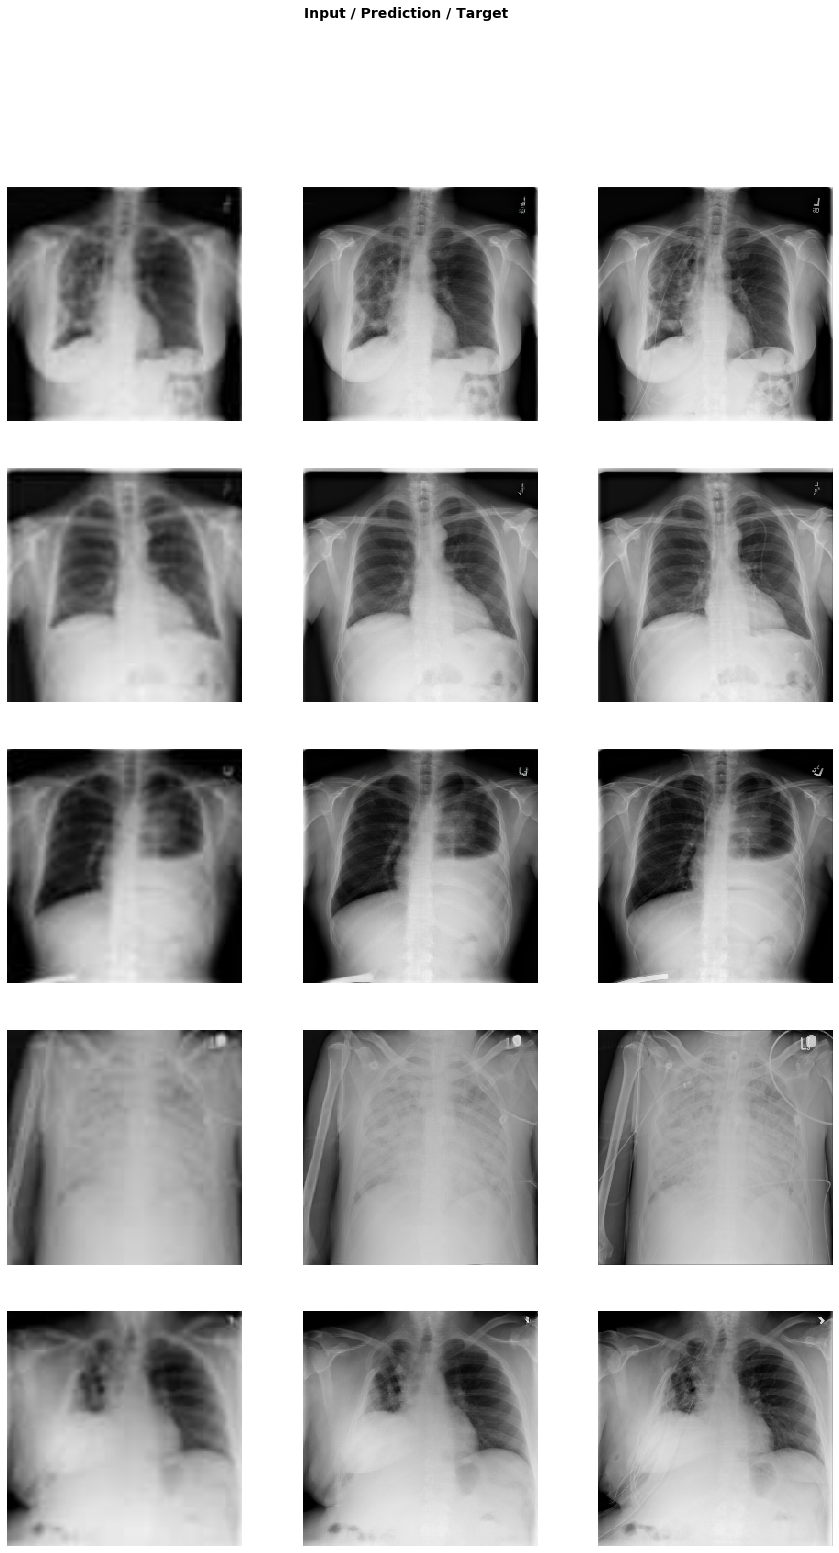

In [23]:
learn.show_results(rows=5, imgsize=5)